# EXPLORATORY DATA ANALYSIS FOR THE SUPERMARKET SIMULATION
This Notebook provides an **analysis** of the raw data, and **reshapes them** in a way suitable for using them to run a MonteCarlo simulation.

In [1]:
import pandas as pd
import datetime

### 1. Loading the csv files

In [2]:
mon = pd.read_csv('data/daily_attendance/raw/monday.csv', sep=';', parse_dates=[0])
tue = pd.read_csv('data/daily_attendance/raw/tuesday.csv', sep=';', parse_dates=[0])
wed = pd.read_csv('data/daily_attendance/raw/wednesday.csv', sep=';', parse_dates=[0])
thu = pd.read_csv('data/daily_attendance/raw/thursday.csv', sep=';', parse_dates=[0])
fri = pd.read_csv('data/daily_attendance/raw/friday.csv', sep=';', parse_dates=[0])

### 2. Adding values for customers' checkout and merging the data into a single dataframe 

In [4]:
def fe_matrix(day):
    '''Add the checkout to the customers who miss it and
    assign unique identifiers for customers over the week.'''

    #find the missing checkouts
    chkt = pd.DataFrame(data=day['customer_no'].value_counts() == 1)
    lst = list(chkt[chkt['customer_no']==True].index)
    
    #append the new rows for missing checkouts
    mnt = day['timestamp'].max()+datetime.timedelta(minutes=1)
    count = 0
    for i in range(len(lst)):
        day.loc[len(day)+count] = [mnt,lst[i],'checkout']
        count = count+1
         
    #update the customer columns adding the weekly day
    lst2 = ['m_','tu_','w_','th_','fr_']
    wd = day.timestamp[1].weekday()
    day['cust_id'] = lst2[wd]+day['customer_no'].astype('str')
   
    return day

In [5]:
mon = fe_matrix(mon)
tue = fe_matrix(tue)
wed = fe_matrix(wed)
thu = fe_matrix(thu)
fri = fe_matrix(fri)
df = pd.concat([mon,tue,wed,thu,fri],ignore_index=True) 
df.set_index('timestamp', inplace=True)

### 3. Expanding table's column

In [6]:
df.sort_index(inplace=True)
df['time'] = df.index.time 
df

,customer_no,location,cust_id,time
timestamp,,,,
2019-09-02 07:03:00,1,dairy,m_1,07:03:00
2019-09-02 07:03:00,2,dairy,m_2,07:03:00
2019-09-02 07:04:00,3,dairy,m_3,07:04:00
2019-09-02 07:04:00,4,dairy,m_4,07:04:00
2019-09-02 07:04:00,5,spices,m_5,07:04:00
...,...,...,...,...
2019-09-06 21:50:00,1509,drinks,fr_1509,21:50:00
2019-09-06 21:50:00,1510,spices,fr_1510,21:50:00
2019-09-06 21:51:00,1510,checkout,fr_1510,21:51:00


### 4. Determining the order of states

In [7]:
# finding the min of time in order to indicate the visited first aile of each customer into the supermarket
first_section = df.reset_index().groupby('cust_id')['timestamp'].min()

In [8]:
# Adding a column 'section_order' for adding 'first' visited aile, 
for customer in df["cust_id"].unique():
    df.loc[
        (df['cust_id'] == customer) & (df.index == first_section[customer]),
        "section_order"
    ] = "first"

#set to 'following' for all other visited ailes 
df.loc[df["location"] == "checkout", "section_order"] = "checkout"

# checkout by customers
df['section_order'].fillna('following', inplace=True)

In [9]:
df

,customer_no,location,cust_id,time,section_order
timestamp,,,,,
2019-09-02 07:03:00,1,dairy,m_1,07:03:00,first
2019-09-02 07:03:00,2,dairy,m_2,07:03:00,first
2019-09-02 07:04:00,3,dairy,m_3,07:04:00,first
2019-09-02 07:04:00,4,dairy,m_4,07:04:00,first
2019-09-02 07:04:00,5,spices,m_5,07:04:00,first
...,...,...,...,...,...
2019-09-06 21:50:00,1509,drinks,fr_1509,21:50:00,first
2019-09-06 21:50:00,1510,spices,fr_1510,21:50:00,first
2019-09-06 21:51:00,1510,checkout,fr_1510,21:51:00,checkout


### 5. Calculating the probabilities for the first section

In [10]:
customers_in_first_sections = (df[df.section_order == 'first'].groupby('location')[['cust_id']].count())
customers_in_first_sections

,cust_id
location,
dairy,2141
drinks,1143
fruit,2810
spices,1351


In [11]:
total_entries = sum(customers_in_first_sections['cust_id'].to_list())
first_probabilities = customers_in_first_sections / total_entries
first_probabilities

,cust_id
location,
dairy,0.287576
drinks,0.153526
fruit,0.377435
spices,0.181464


### 6. Calculating the total number of customers in each location

In [12]:
location_sum = df.groupby('location')[['cust_id']].count().sort_values('cust_id')
location_sum

,cust_id
location,
spices,3754
drinks,3905
dairy,4679
fruit,5122
checkout,7426


In [13]:
# daily average of customer per location
location_avg = round(location_sum / 5, 0).astype(int)
location_avg

,cust_id
location,
spices,751
drinks,781
dairy,936
fruit,1024
checkout,1485


### 7. Calculating the number of customer per location over time

In [14]:
# weekly number of customer per location per min
df.groupby(['time', 'location'])[['cust_id']].count()

cust_id
time     location         
07:00:00 dairy           3
         drinks          3
         fruit           4
07:01:00 checkout        2
         dairy           4
...                    ...
21:50:00 dairy           3
         drinks          1
         fruit           2
         spices          1
21:51:00 checkout        7

[4384 rows x 1 columns]

In [15]:
# average (daily) customer per min per location
avg_customers_location = df.groupby(['time', 'location'])[['cust_id']].count()/5
avg_customers_location

cust_id
time     location         
07:00:00 dairy         0.6
         drinks        0.6
         fruit         0.8
07:01:00 checkout      0.4
         dairy         0.8
...                    ...
21:50:00 dairy         0.6
         drinks        0.2
         fruit         0.4
         spices        0.2
21:51:00 checkout      1.4

[4384 rows x 1 columns]

In [16]:
# total number of customers per min per location
customers_location = df.groupby([df.index, 'location'])[['cust_id']].count()
customers_location

cust_id
timestamp           location         
2019-09-02 07:03:00 dairy           2
2019-09-02 07:04:00 dairy           2
                    fruit           1
                    spices          3
2019-09-02 07:05:00 checkout        2
...                               ...
2019-09-06 21:50:00 dairy           1
                    drinks          1
                    fruit           1
                    spices          1
2019-09-06 21:51:00 checkout        3

[13842 rows x 1 columns]

### 8. Calculating the number of customers at checkout over time

In [17]:
# weekly number of customers at checkout over the time
checkout = df[df['location'] == 'checkout']
checkout.groupby(['timestamp', 'location'])[['cust_id']].count()

,,cust_id
timestamp,location,
2019-09-02 07:05:00,checkout,2
2019-09-02 07:06:00,checkout,2
2019-09-02 07:07:00,checkout,1
2019-09-02 07:08:00,checkout,3
2019-09-02 07:09:00,checkout,1
...,...,...
2019-09-06 21:45:00,checkout,1
2019-09-06 21:47:00,checkout,2
2019-09-06 21:48:00,checkout,2


In [18]:
# daily number of customers at checkout over the time
checkout.groupby(['time', 'location'])[['cust_id']].count()/5

,,cust_id
time,location,
07:01:00,checkout,0.4
07:02:00,checkout,1.0
07:03:00,checkout,0.2
07:04:00,checkout,0.4
07:05:00,checkout,1.4
...,...,...
21:47:00,checkout,1.0
21:48:00,checkout,1.4
21:49:00,checkout,1.2


### 9. Time spent in the supermarket

In [19]:
# making a df with customer_id and time at first location
first_location = df.reset_index()[['timestamp', 'cust_id']].groupby('cust_id').min()
first_location.rename(columns={'timestamp': 'entrance_time'}, inplace=True)
first_location.sort_values('entrance_time')

,entrance_time
cust_id,
m_1,2019-09-02 07:03:00
m_2,2019-09-02 07:03:00
m_4,2019-09-02 07:04:00
m_3,2019-09-02 07:04:00
m_5,2019-09-02 07:04:00
...,...
fr_1506,2019-09-06 21:48:00
fr_1507,2019-09-06 21:48:00
fr_1508,2019-09-06 21:48:00


In [20]:
# making a df with customer_id and time at checkout
checkout = df.reset_index()[['timestamp', 'cust_id']].groupby('cust_id').max()
checkout.rename(columns={'timestamp': 'exit_time'}, inplace=True)
checkout.sort_values('exit_time')

,exit_time
cust_id,
m_1,2019-09-02 07:05:00
m_5,2019-09-02 07:05:00
m_3,2019-09-02 07:06:00
m_2,2019-09-02 07:06:00
m_8,2019-09-02 07:07:00
...,...
fr_1496,2019-09-06 21:50:00
fr_1507,2019-09-06 21:50:00
fr_1510,2019-09-06 21:51:00


In [21]:
time_in_market = pd.concat([first_location, checkout], axis=1)
time_in_market['total_time'] = (time_in_market['exit_time'] - time_in_market['entrance_time'])
time_in_market.sort_values('entrance_time')

,entrance_time,exit_time,total_time
cust_id,,,
m_1,2019-09-02 07:03:00,2019-09-02 07:05:00,0 days 00:02:00
m_2,2019-09-02 07:03:00,2019-09-02 07:06:00,0 days 00:03:00
m_4,2019-09-02 07:04:00,2019-09-02 07:08:00,0 days 00:04:00
m_3,2019-09-02 07:04:00,2019-09-02 07:06:00,0 days 00:02:00
m_5,2019-09-02 07:04:00,2019-09-02 07:05:00,0 days 00:01:00
...,...,...,...
fr_1506,2019-09-06 21:48:00,2019-09-06 21:51:00,0 days 00:03:00
fr_1507,2019-09-06 21:48:00,2019-09-06 21:50:00,0 days 00:02:00
fr_1508,2019-09-06 21:48:00,2019-09-06 21:50:00,0 days 00:02:00


### 10. Total number of customers present in the supermarket over time

In [22]:
# tracking the location of each customer per minute
df_final = df.groupby(['cust_id']).resample('min').ffill()
df_final

customer_no  location cust_id      time  \
cust_id timestamp                                                      
fr_1    2019-09-06 07:00:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:01:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:02:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:03:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:04:00            1    spices    fr_1  07:04:00   
...                                  ...       ...     ...       ...   
w_998   2019-09-04 16:57:00          998     fruit   w_998  16:57:00   
        2019-09-04 16:58:00          998     fruit   w_998  16:57:00   
        2019-09-04 16:59:00          998  checkout   w_998  16:59:00   
w_999   2019-09-04 16:53:00          999     fruit   w_999  16:53:00   
        2019-09-04 16:54:00          999  checkout   w_999  16:54:00   

                            section_order  
cust_id timestamp                          
fr_1    2019-09-06 07:00:00         first  
        2019-09-06 07:01:00         first  
        2019-09-06 07:02:00         first  
        2019-09-06 07:03:00         first  
        2019-09-06 07:04:00     following  
...                                   ...  
w_998   2019-09-04 16:57:00     following  
        2019-09-04 16:58:00     following  
        2019-09-04 16:59:00      checkout  
w_999   2019-09-04 16:53:00         first  
        2019-09-04 16:54:00      checkout  

[53921 rows x 5 columns]

In [23]:
# checking the old and new data to see if it works 
df[df['cust_id'] == 'fr_1']

,customer_no,location,cust_id,time,section_order
timestamp,,,,,
2019-09-06 07:00:00,1,dairy,fr_1,07:00:00,first
2019-09-06 07:04:00,1,spices,fr_1,07:04:00,following
2019-09-06 07:05:00,1,checkout,fr_1,07:05:00,checkout


In [24]:
df_final[df_final['cust_id'] == 'fr_1']

customer_no  location cust_id      time  \
cust_id timestamp                                                      
fr_1    2019-09-06 07:00:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:01:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:02:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:03:00            1     dairy    fr_1  07:00:00   
        2019-09-06 07:04:00            1    spices    fr_1  07:04:00   
        2019-09-06 07:05:00            1  checkout    fr_1  07:05:00   

                            section_order  
cust_id timestamp                          
fr_1    2019-09-06 07:00:00         first  
        2019-09-06 07:01:00         first  
        2019-09-06 07:02:00         first  
        2019-09-06 07:03:00         first  
        2019-09-06 07:04:00     following  
        2019-09-06 07:05:00      checkout

In [25]:
df_final.reset_index(inplace=True, level=0, drop=True)
df_final

,customer_no,location,cust_id,time,section_order
timestamp,,,,,
2019-09-06 07:00:00,1,dairy,fr_1,07:00:00,first
2019-09-06 07:01:00,1,dairy,fr_1,07:00:00,first
2019-09-06 07:02:00,1,dairy,fr_1,07:00:00,first
2019-09-06 07:03:00,1,dairy,fr_1,07:00:00,first
2019-09-06 07:04:00,1,spices,fr_1,07:04:00,following
...,...,...,...,...,...
2019-09-04 16:57:00,998,fruit,w_998,16:57:00,following
2019-09-04 16:58:00,998,fruit,w_998,16:57:00,following
2019-09-04 16:59:00,998,checkout,w_998,16:59:00,checkout


### 11. Plotting the distribution of customers of their first visited location vs. following locations

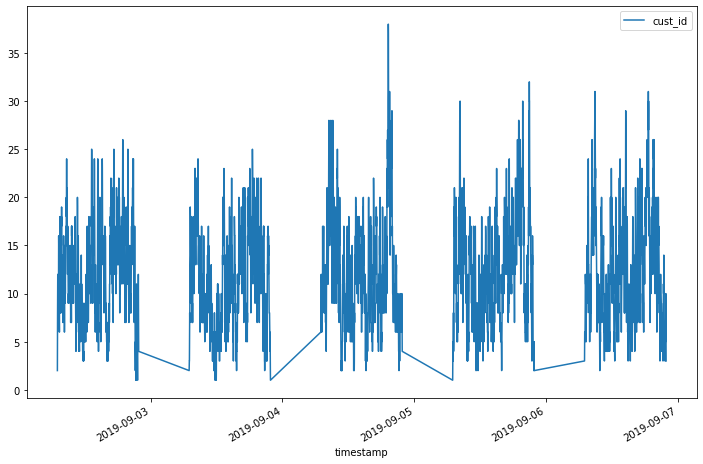

In [26]:
df_final.groupby(df_final.index)[['cust_id']].count().plot(figsize=(12,8));

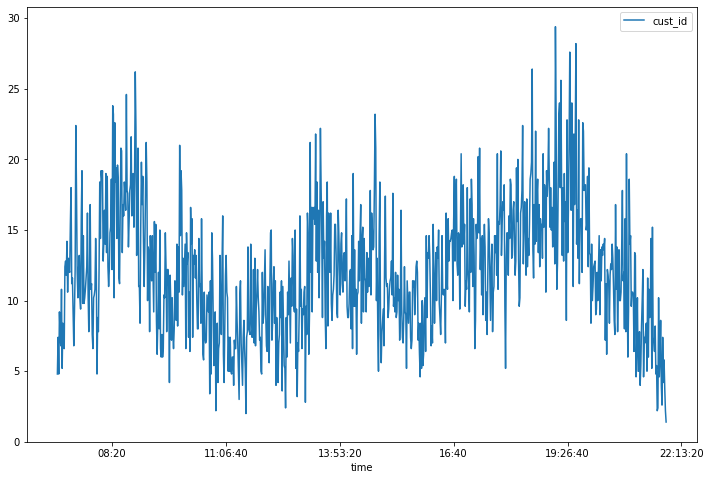

In [27]:
(df_final.groupby(df_final['time'])[["cust_id"]].count() / 5).plot(figsize=(12, 8));

In [28]:
# Average (daily) number of customers at first location per minute
first = (df_final[df_final["section_order"] == "first"].groupby(["time"])[["cust_id"]].count()/5)
# Average (daily) number of customers at following locations per minute
following = (df_final[df_final["section_order"] == "following"].groupby(["time"])[["cust_id"]].count()/5)


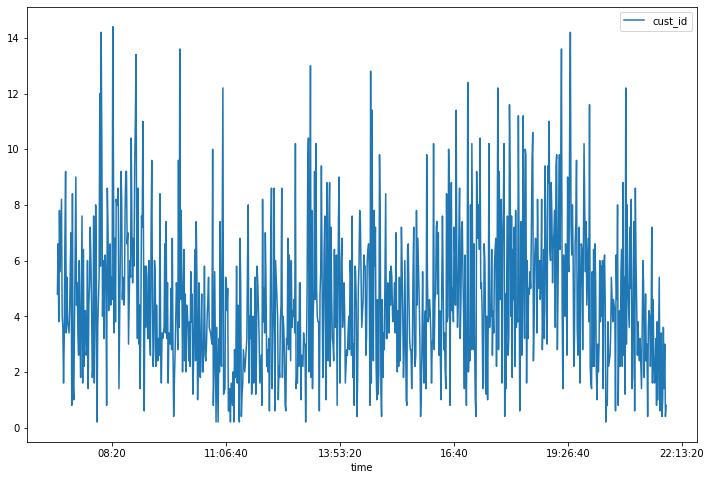

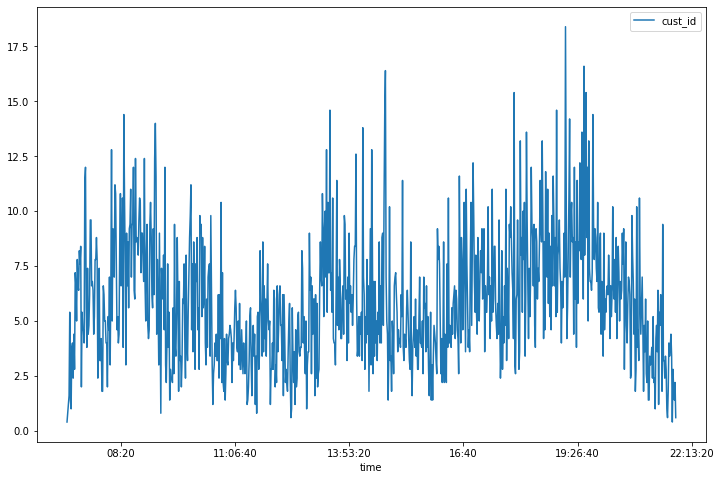

In [29]:
first.plot(figsize=(12,8))
following.plot(figsize=(12,8));

### 12. Saving the final version of dataframe into the CSV file 
**N.B:** _A Transition Matrix for the MCMC simulation is calulated in the module `MCMC_Simulation/transition_matrix.py`. 

In [34]:
df_final = df_final.sort_values(["timestamp", "cust_id"])
df_final.to_csv('data/daily_attendance/cleaned_up/clean_final.csv')